# Project Machine Learning LELEC2870

## Import 


In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression


In [134]:
# import data set
explanatory_train_raw = pd.read_csv('X1.csv')
train_target = pd.read_csv('Y1.csv', header=None)
train_target.columns = ["target"]

## Data Exploratory Analysis 

### valid data set check 

In [135]:
# check wether dataset contains null values
print(explanatory_train_raw[["Age", "Height"]].isnull().sum())

# check wether dataset contains missing values
explanatory_train_raw.dropna()
print(explanatory_train_raw.count())

Age       0
Height    0
dtype: int64
Unnamed: 0                        250
Gender                            250
Age                               250
Height                            250
family_history_with_overweight    250
FAVC                              250
FCVC                              250
NCP                               250
CAEC                              250
SMOKE                             250
CH2O                              250
SCC                               250
FAF                               250
TUE                               250
CALC                              250
MTRANS                            250
dtype: int64


-> No null or missing observations for continuous variables

### continuous variables 

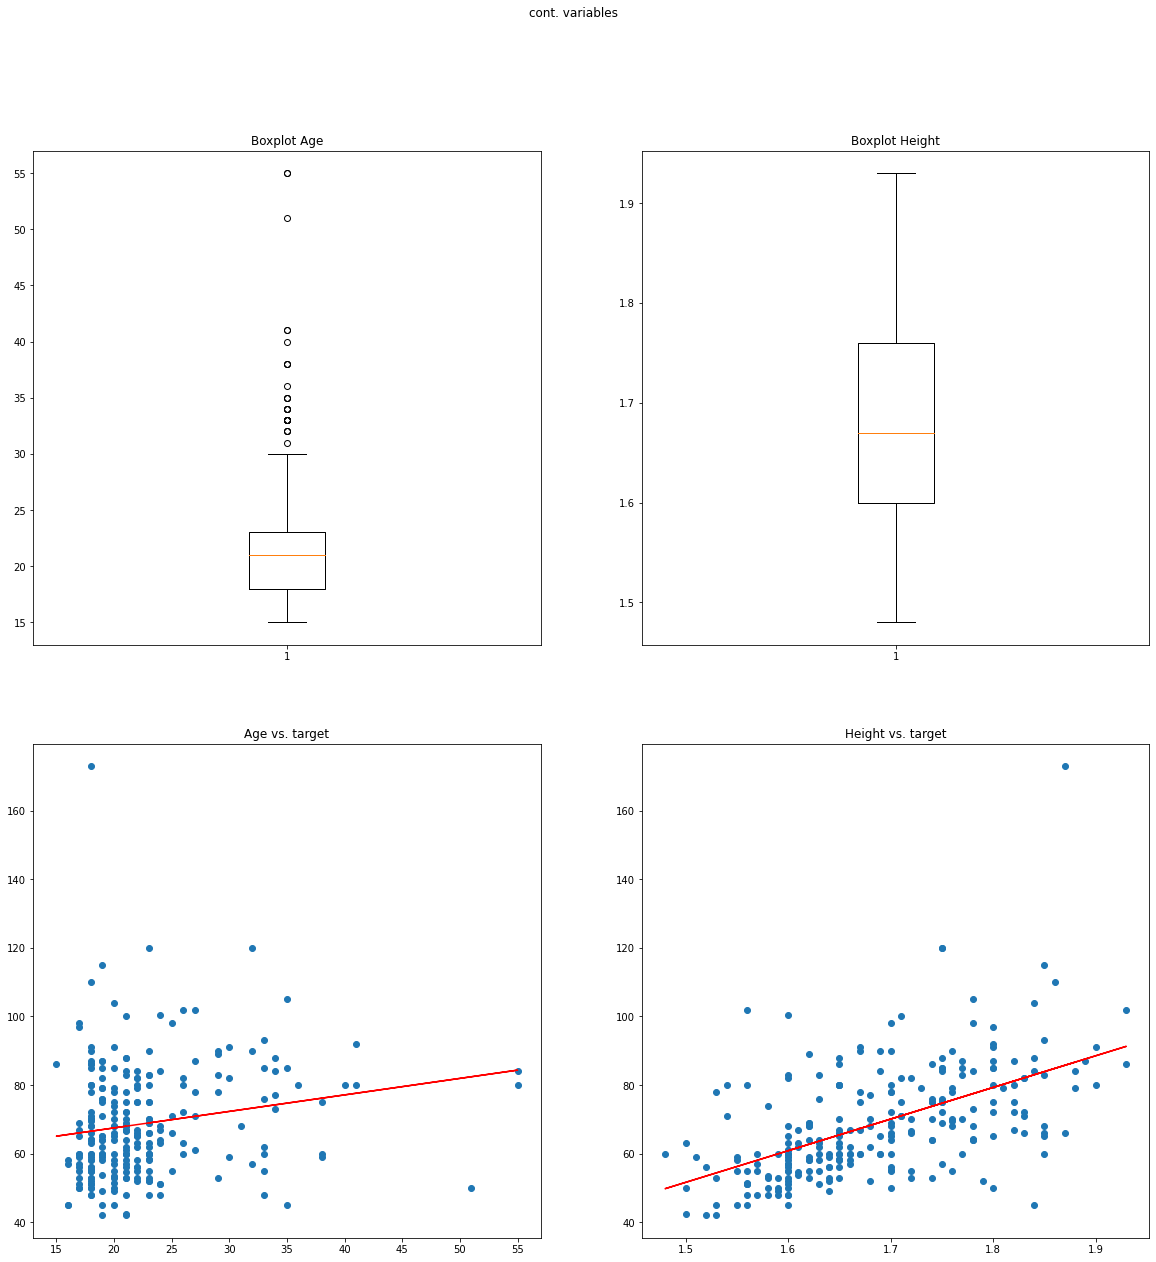

In [136]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.suptitle("cont. variables")

axes[0,0].boxplot(explanatory_train_raw["Age"])
axes[0,0].set_title('Boxplot Age')
axes[0,1].boxplot(explanatory_train_raw["Height"])
axes[0,1].set_title('Boxplot Height')

""" linearity between cont. var and target var """

# scat_plot_1
x = explanatory_train_raw['Age']
y = train_target['target']

stats = linregress(x, y)

m = stats.slope
b = stats.intercept

axes[1,0].scatter(x, y)
axes[1,0].plot(x, m * x + b, color='red')
axes[1,0].set_title('Age vs. target')

# scat_plot_2
x = explanatory_train_raw['Height']
y = train_target['target']

stats = linregress(x, y)

m = stats.slope
b = stats.intercept

axes[1,1].scatter(x, y)
axes[1,1].plot(x, m * x + b, color='red')
axes[1,1].set_title('Height vs. target')

plt.rcParams['figure.figsize'] = (10, 10)
plt.show()



$\bold{Age}$ is highly skewed, might be a problem for linreg later on whereas, $\bold{Height}$ seems to have no outliers

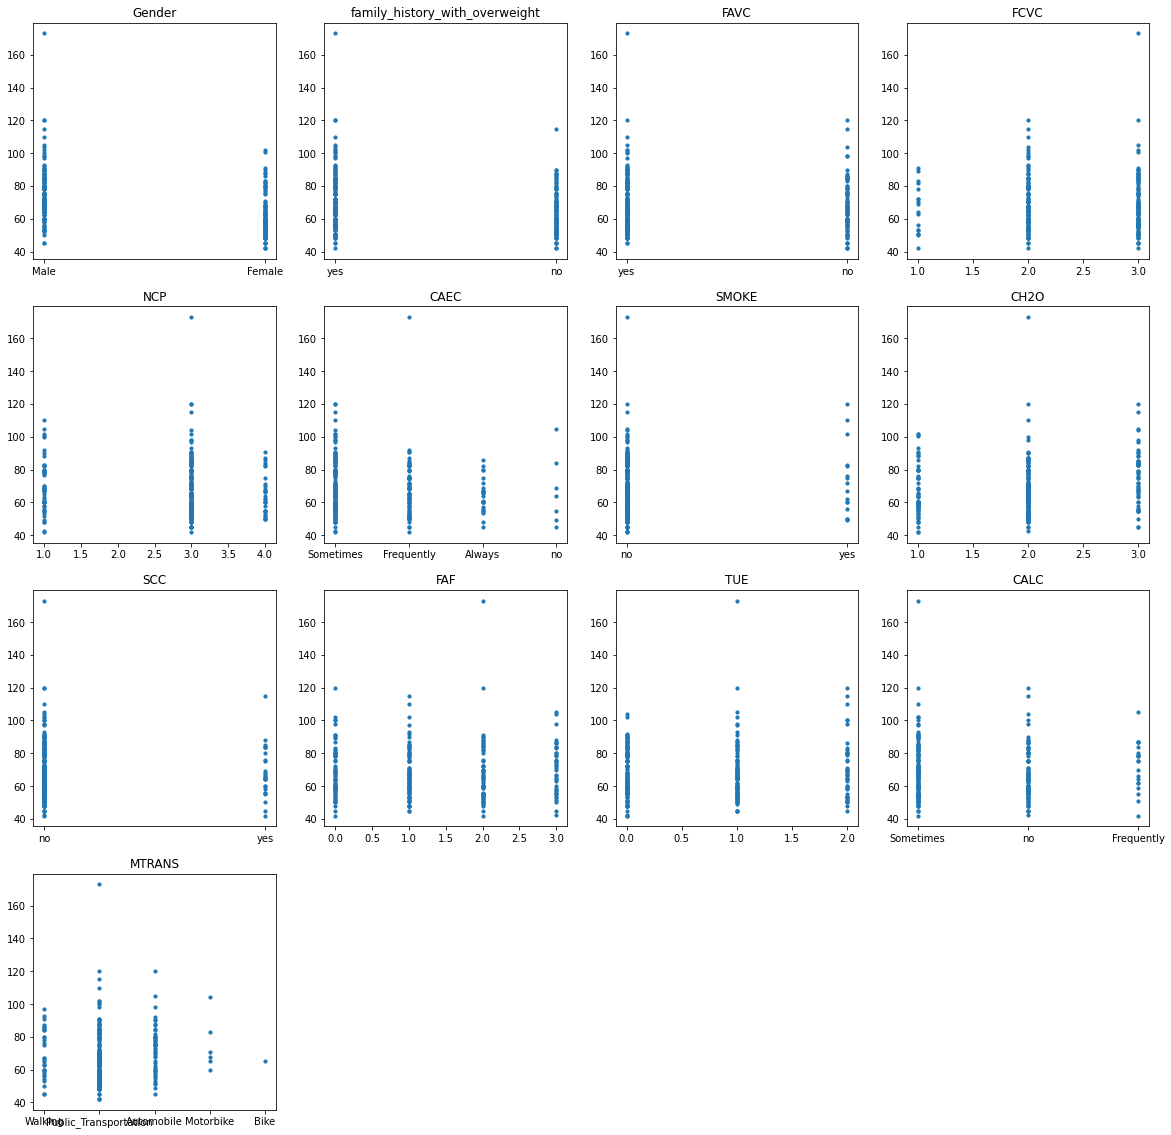

In [142]:
var_names = ['Gender', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 
'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS']
n_feats = len(var_names)
# 15 features

for i, var in enumerate(var_names):
    plt.subplot((n_feats//4+1), 4, i+1)
    plt.scatter(explanatory_train_raw[var], train_target, s=10)
    plt.title(var_names[i])

plt.rcParams['figure.figsize'] = (20, 20)
plt.tight_layout
plt.show()



We need to pay attention to the fact that all the categories are not well balanced. i.e, there are way less non-smoker than smoker in the study 



In [143]:
# Data Cleaning :
# Je modifie les variable catégorielle sous forme de nombre en mots compréhensibles, c'est mieux pour la suite

# Création du dictionnaire
cleaned_gender = {"FCVC": {1.0: "Never", 2.0: "Sometimes", 3.0: "Always"},
                  "NCP": {1.0: "Betw1_2", 2.0: "Three", 3.0: "Tree++"},
                  "CH2O": {1.0: "Less1L", 2.0: "Betw1_2", 3.0: "Two++"},
                  "FAF": {1.0: "no_acti", 2.0: "1_2Day", 3.0: "2_4Day", 4.0: "4_5Day"},
                  "TUE": {1.0: "0_2hour", 2.0: "3_5hour", 3.0: "Five++"}}

# Remplacement dans le dataframe
explanatory_train_raw = explanatory_train_raw.replace(cleaned_gender)

# Binarized categorical variables
explanatory_train = pd.get_dummies(explanatory_train_raw,
                                   columns=["Gender", "family_history_with_overweight", "FAVC", "FCVC", "NCP", "CAEC",
                                            "SMOKE", "CH2O", "SCC", "FAF", "TUE", "CALC", "MTRANS"],
                                   prefix=["Gender", "family_history_with_overweight", "FAVC", "FCVC", "NCP", "CAEC",
                                           "SMOKE", "CH2O", "SCC", "FAF", "TUE", "CALC", "MTRANS"])

                                           

## model : linear regression 

In [161]:
# bmi calculator 
def get_bmi(w, h):
    return w/h**2


# RMSE calculator  
def compute_rmse(predict, target):
        # SOLUTION
    if len(target.shape) == 2:
        target = target.squeeze()
    if len(predict.shape) == 2:
        predict = predict.squeeze()
    diff = target - predict
    if len(diff.shape) == 1:
        diff = np.expand_dims(diff, axis=-1)
    rmse = np.sqrt(diff.T@diff / diff.shape[0])
    return float(rmse)

def score_weight_class(bmi_pred, bmi_true, low, high):
    tol = 1
    vpred = (bmi_pred>=low-tol) & (bmi_pred<high+tol)
    vtrue = (bmi_true>=low) & (bmi_true<high)
    if vtrue.sum()==0:
        print("no true sample here")
        return 0
    
    rmse = np.sqrt(((bmi_true[vtrue]-bmi_pred[vtrue])**2).mean())
    rmse = rmse/(high-low+tol)
    acc = (vpred&vtrue).sum()/vtrue.sum()
    return rmse*(1-acc)


def score_regression(ytrue, ypred, height):
    bmi_pred = ypred/(height*height)
    bmi_true = ytrue/(height*height)

    score = []
    for bmi_low, bmi_high in zip([0,18.5,25,30],[18.5, 25, 30, 100]):
        score.append(score_weight_class(bmi_pred, bmi_true, low = bmi_low, high = bmi_high))
        return np.mean(score)



model = LinearRegression().fit(explanatory_train,train_target)
target_pred = model.predict(explanatory_train)

# R^2
r_sq = model.score(explanatory_train,train_target)
print('coefficient of determination:', round(r_sq, 4))

# RMSE 
print(round(compute_rmse(target_pred, train_target),4))

print(score_regression(train_target, target_pred, explanatory_train['Height']))






coefficient of determination: 0.4393
12.3608


ValueError: Data must be 1-dimensional